In [274]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
from shapely.ops import split

# Read terminus boxes and traces
boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
traces = gpd.read_file("../data/terminus/terminus_traces_1985_2023.geojson")

# To store trace-terminated boxes before combined
boxes_gdf = []

# Subset data by current glacier
for glacier, traces_glacier in traces.groupby(by="glacier_code"):
    traces_glacier = traces_glacier.sort_values(by="date", ascending=False)
    box = boxes.loc[boxes.glacier_code == glacier].reset_index()

    for i, trace in traces_glacier.iterrows():
        # Attempt to split box by terminus trace
        difference = split(box.geometry.item(), trace.geometry.geoms[0])

        start_relocate_distance = None
        end_relocate_distance = None

        # If split was unsuccessful then extend trace to fully intersect box
        if len(difference.geoms) == 1:
            # Alias necessary geometry
            box_poly = box.geometry.item().geoms[0]
            box_edge = box_poly.exterior
            trace_line = trace.geometry.geoms[0]
            trace_start_coords = trace_line.coords[0]
            trace_end_coords = trace_line.coords[-1]
            trace_start_point = Point(trace_start_coords)
            trace_end_point = Point(trace_end_coords)

            # Copy of trace where relocated start/end coords will be inserted
            trace_line_extended = list(trace_line.coords)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_start_point):
                start_interp = box_edge.interpolate(box_edge.project(trace_start_point))
                shifted = box_edge.interpolate(box_edge.project(start_interp) - 10)
                vector = np.array(start_interp.coords[0]) - np.array(shifted.coords[0])
                start_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                start_interp_extended = (
                    start_interp.x - start_interp_extended[0] * 50,
                    start_interp.y - start_interp_extended[1] * 50,
                )
                trace_line_extended[0] = start_interp_extended
                start_relocate_distance = start_interp.distance(trace_start_point)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_end_point):
                end_interp = box_edge.interpolate(box_edge.project(trace_end_point))
                shifted = box_edge.interpolate(box_edge.project(end_interp) + 50)
                vector = np.array(end_interp.coords[0]) - np.array(shifted.coords[0])
                end_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                end_interp_extended = (
                    end_interp.x + end_interp_extended[0] * 50,
                    end_interp.y + end_interp_extended[1] * 50,
                )
                trace_line_extended[-1] = end_interp_extended
                end_relocate_distance = end_interp.distance(trace_end_point)

            # Reconstructs trace line with new start and/or end coords
            trace_line_extended = LineString(trace_line_extended)

            # Splits box by interpolated trace
            difference = split(box.geometry[0], trace_line_extended)

            # # PLOT: INITIAL STATE
            # box.geometry.plot(color="grey", alpha=0.5, edgecolor="black")
            # plt.fill(*difference.geoms[1].exterior.xy, linewidth=1, c="red", alpha=0.2)
            # plt.plot(*trace_line_extended.xy, linewidth=1, c="blue")
            # plt.plot(*trace_line.xy, linestyle="-", linewidth=1, c="orange")
            # plt.plot(*trace_start_coords, marker="o", markersize=2, c="green")
            # plt.plot(*trace_end_coords, marker="o", markersize=2, c="red")
            # plt.show()

        # Assign attributes from trace to trace-terminated box
        box_gdf = trace.drop(labels="geometry")
        box_gdf["geometry"] = difference.geoms[1]
        box_gdf["area"] = difference.geoms[1].area
        box_gdf["area_width_averaged"] = difference.geoms[1].area / box.width[0]
        box_gdf["start_relocate_distance"] = start_relocate_distance
        box_gdf["end_relocate_distance"] = end_relocate_distance
        box_gdf = gpd.GeoDataFrame(box_gdf).transpose()
        box_gdf = box_gdf.set_geometry("geometry").set_crs(3413)
        boxes_gdf.append(box_gdf)

# Concat trace-terminated boxes into one GeoDataFrame, sort, and set index
boxes_gdf = pd.concat(boxes_gdf, ignore_index=True)
boxes_gdf = boxes_gdf.sort_values(by=["glacier_code", "date"]).set_index(["glacier_code"])

In [275]:
# Calculate change in width-averaged area terminus relative to earliest observation [m]
boxes_gdf["area_width_averaged_change"] = boxes_gdf.area_width_averaged - boxes_gdf.groupby(
    "glacier_code"
).area_width_averaged.transform("first")

# Convert date to datetime and calculate difference in date pairs
boxes_gdf["date"] = pd.to_datetime(boxes_gdf.date)
boxes_gdf["d_date"] = boxes_gdf.date - boxes_gdf.groupby("glacier_code").date.transform("first")

# Calculate rate of retreat [m a-1]
boxes_gdf["retreat_rate"] = (
    boxes_gdf.area_width_averaged_change.divide(
        boxes_gdf.d_date.dt.days.where(boxes_gdf.d_date.dt.days != 0, np.nan).shift(-1)
    )
    * 365
)

In [276]:
# Convert Timedelta to string to allow export
boxes_gdf["d_date"] = boxes_gdf.d_date.astype(str)

# Write results to disk
boxes_gdf.to_file("../data/terminus/terminus_boxes_1985_2023.geojson", driver="GeoJSON")
boxes_gdf.to_csv("../data/terminus/terminus_boxes_1985_2023.csv")
boxes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1056 entries, DJ to UI
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1056 non-null   datetime64[ns]
 1   image_id                    995 non-null    object        
 2   satellite                   995 non-null    object        
 3   quality                     1056 non-null   object        
 4   glacier                     1056 non-null   object        
 5   source                      1056 non-null   object        
 6   order                       0 non-null      object        
 7   geometry                    1056 non-null   geometry      
 8   area                        1056 non-null   object        
 9   area_width_averaged         1056 non-null   object        
 10  start_relocate_distance     96 non-null     object        
 11  end_relocate_distance       132 non-null    object    

<Axes: >

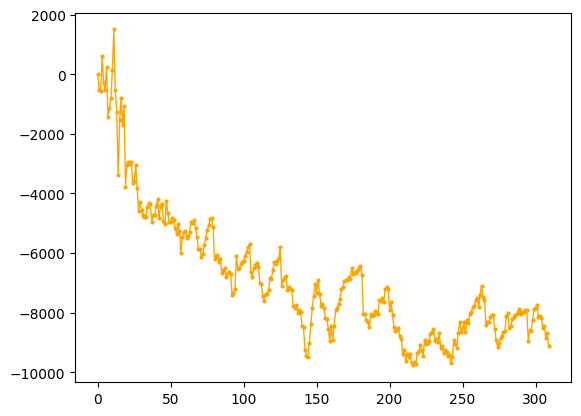

In [135]:
boxes_gdf.loc[boxes_gdf.index == "UI"].area_width_averaged_change.plot(
    use_index=False, c="orange", marker="o", markersize=2, linewidth=1
)